In [1]:
import numpy as np
import math
from numpy.linalg import inv
import matplotlib.pyplot as plt
from numpy.linalg import cholesky, det
from scipy.linalg import solve_triangular
from scipy.optimize import minimize
from scipy.integrate import solve_ivp

import gpflow as gpf
from gpflow.utilities import print_summary
from gpflow.utilities import parameter_dict
from gpflow.ci_utils import reduce_in_tests

import tensorflow as tf

gpf.config.set_default_float(np.float64)
gpf.config.set_default_summary_fmt("notebook")
np.random.seed(0)

MAXITER = reduce_in_tests(5000)


In [4]:
## The idea is that we simulate from a lotka volterra model with three species. This model has three growth rates, mu, plus an interaction matrix, M
## We then fit Gaussian processes to the time courses and use model selection to determine the best combination of kernels and mean functions to model the data
## What we ultimately want to know is how the original parameters of the LV model correspond to the best fitting GPs
## This will enable us to work out what information is contained in the GPs

(3, 31)


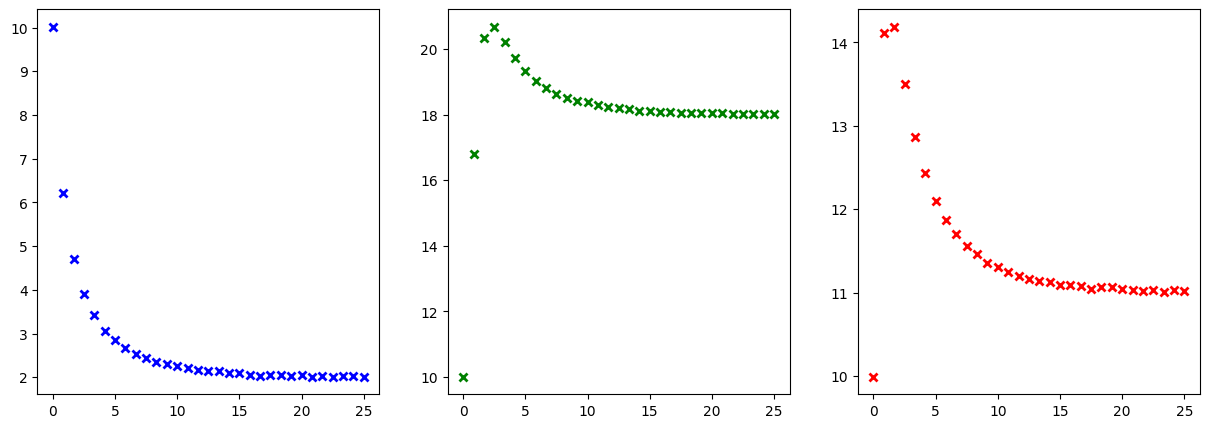

In [2]:
# This function is the Lotka-Volterra predator-prey model
# It takes two arguments: t, the time, and y, a vector of the current population sizes
# It returns a list of the time derivatives of the populations, in the same order as the input

def lotka_volterra(t, y):
    mu = [0.2, 0.7, 0.9]
    M = np.array([[-0.1, 0.0, 0.0], [0.0,-0.1, 0.1], [0.1, 0.0, -0.1]])

    y1 = y[0]
    y2 = y[1]
    y3 = y[2]
    
    dy1 = y1*mu[0] + y1*( M[0,0]*y1 + M[0,1]*y2 + M[0,2]*y3 )
    dy2 = y2*mu[1] + y2*( M[1,0]*y1 + M[1,1]*y2 + M[1,2]*y3 )
    dy3 = y3*mu[2] + y3*( M[2,0]*y1 + M[2,1]*y2 + M[2,2]*y3 ) 
    
    return [dy1, dy2, dy3]

def simulate(y0, t):
  return solve_ivp(fun=lotka_volterra, t_span=[min(t), max(t)], y0=y0, t_eval=t, method='LSODA')

nps = 31
t = np.linspace(0, 25, nps)
y0 = [10.0, 10.0, 10.0]
sol = simulate(y0, t)

# sample data points
# s_idx = np.random.choice(len(t), size = 101, replace=False)
# s_idx.sort()
s_idx = np.arange(nps)
ts = sol.t[s_idx]
ys = sol.y[:,s_idx]

# add noise to growth data
y_hat = np.maximum(ys + np.random.normal(scale=0.01, size=ys.shape), 0)

print(y_hat.shape)

fig, ax = plt.subplots(figsize=(15,5),ncols=3,nrows=1)
ax[0].plot(ts, y_hat[0,:], "bx", mew=2);
ax[1].plot(ts, y_hat[1,:], "gx", mew=2);
ax[2].plot(ts, y_hat[2,:], "rx", mew=2);


In [77]:
# Fit whole system using various multi-ouput kernels and VGP


def plot_gp_d(x, mu, var, color, label, ax):
    ax.plot(x, mu, color=color, lw=2, label=label)
    ax.fill_between(
        x[:, 0],
        (mu - 2 * np.sqrt(var))[:, 0],
        (mu + 2 * np.sqrt(var))[:, 0],
        color=color,
        alpha=0.4,
    )
    ax.set_xlabel("X")
    ax.set_ylabel("y")

def plot_model(m, X):
    fig, ax = plt.subplots(figsize=(15,5),ncols=3,nrows=1)
    ax[0].plot(X[:,0], Y[:,0], "bx", mew=2);
    ax[1].plot(X[:,0], Y[:,1], "gx", mew=2);
    ax[2].plot(X[:,0], Y[:,2], "rx", mew=2);

    # just use the GP to predict at same timepoints
    mu1, var1 = m.predict_y(np.hstack((X, np.zeros_like(X)) ))
    plot_gp_d(X, mu1, var1, "b", "Y1", ax[0])

    mu2, var2 = m.predict_y(np.hstack((X, np.ones_like(X)) ))
    plot_gp_d(X, mu2, var2, "g", "Y2", ax[1])

    mu3, var3 = m.predict_y(np.hstack((X, 2*np.ones_like(X)) ))
    plot_gp_d(X, mu3, var3, "r", "Y3", ax[2]);
    
def optimize_model_with_scipy(model):
    optimizer = gpf.optimizers.Scipy()
    res = optimizer.minimize(
        model.training_loss_closure( (X,Y) ),
        variables=model.trainable_variables,
        method="l-bfgs-b",
        #options={"disp": 50, "maxiter": MAXITER},
        options={"maxiter": MAXITER},
    )
    return res

def count_params(m):
    p_dict = parameter_dict(m)
    p_count = 0
    for val in p_dict.values():
        #print(val.shape)
        if len(val.shape) == 0:
            p_count = p_count + 1
        else:
            p_count = p_count + math.prod( val.shape )

    return p_count

## This is for model selection: the lower the BIC the better the model
def get_BIC(m, F, n):
    # Assumes F = -lnL
    k = count_params(m)
    return k*np.log(n) + 2*F


In [66]:
## Here do coregionalization to estimate f(x) = W g(x)
## https://gpflow.github.io/GPflow/2.8.0/notebooks/advanced/multioutput.html
## https://gpflow.github.io/GPflow/develop/notebooks/getting_started/mean_functions.html
## https://towardsdatascience.com/sparse-and-variational-gaussian-process-what-to-do-when-data-is-large-2d3959f430e7
## https://gpflow.readthedocs.io/en/v1.5.1-docs/notebooks/advanced/coregionalisation.html
## https://gpflow.github.io/GPflow/2.4.0/notebooks/advanced/coregionalisation.html
# This uses VGP

X = ts.reshape(-1,1)
Y = y_hat.T

print(X.shape)
print(Y.shape)

# Augment the input with ones or zeros to indicate the required output dimension
X_aug = np.vstack(
    (np.hstack((X, np.zeros_like(X))), 
     np.hstack((X, np.ones_like(X))),
     np.hstack((X, 2*np.ones_like(X)))
    )
)

# Augment the Y data with ones or zeros that specify a likelihood from the list of likelihoods
Y1 = Y[:,0].reshape(-1,1)
Y2 = Y[:,1].reshape(-1,1)
Y3 = Y[:,2].reshape(-1,1)
                
Y_aug = np.vstack(
    (np.hstack((Y1, np.zeros_like(Y1))), 
     np.hstack((Y2, np.ones_like(Y2))), 
     np.hstack((Y3, 2*np.ones_like(Y3)))
    )
)

#print(X)
#print(X_aug)
#print(Y_aug)

(31, 1)
(31, 3)


name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,8.0767
VGP.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,19.99951
VGP.kernel.kernels[1].W,Parameter,Identity,,True,"(3, 1)",float64,[[-4.52765] [ 8.93373] [ 5.40018]]
VGP.kernel.kernels[1].kappa,Parameter,Softplus,,True,"(3,)",float64,[4.34043 4.15083 2.78003]
VGP.likelihood.likelihoods[0].variance,Parameter,Softplus + Shift,,True,(),float64,0.00237
VGP.likelihood.likelihoods[1].variance,Parameter,Softplus + Shift,,True,(),float64,0.00188
VGP.likelihood.likelihoods[2].variance,Parameter,Softplus + Shift,,True,(),float64,0.03165
VGP.num_data,Parameter,Identity,,False,(),int32,93
VGP.q_mu,Parameter,Identity,,True,"(93, 1)",float64,[[7.04570e-01...
VGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 93, 93)",float64,"[[[3.3500e-03, 0.0000e+00, 0.0000e+00..."


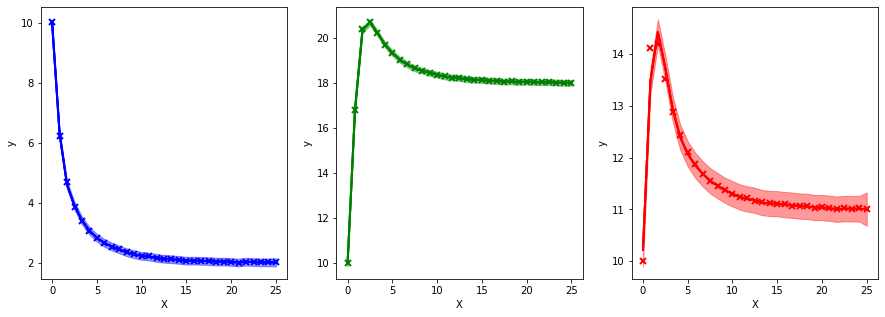

In [80]:
L = 1 # latent processes, g in R^L
P = 3 # observed processes, f in R^P

# Base kernel
k = gpf.kernels.Matern32(active_dims=[0])
#k = gpf.kernels.SquaredExponential(active_dims=[0])

# Coregion kernel
coreg = gpf.kernels.Coregion(
    output_dim=P, 
    rank=L, 
    active_dims=[1]
)

kern = k * coreg

# This likelihood switches between Gaussian noise with different variances for each f_i:
lik = gpf.likelihoods.SwitchedLikelihood(
    [gpf.likelihoods.Gaussian(), gpf.likelihoods.Gaussian(), gpf.likelihoods.Gaussian()]
)

# now build the GP model as normal
m = gpf.models.VGP((X_aug, Y_aug), kernel=kern, likelihood=lik)

# fit the covariance function parameters
maxiter = reduce_in_tests(10000)
res = gpf.optimizers.Scipy().minimize(
        m.training_loss,
        m.trainable_variables,
        options=dict(maxiter=maxiter),
        method="L-BFGS-B",
    )

print_summary(m)
#plot_model(m)
BIC = get_BIC(m,res.fun,X.shape[0])
print(BIC)
plot_model(m,X)

In [92]:
## Wrap above code into a funtion
# P is the number of outputs (three in this case for the three species)
# L is the number of latent processes
# K_L is the kernel for the latent processes
# M_F is the mean function applied to latent processes

def fit_model(X_aug, Y_aug, P, L, K_L=gpf.kernels.SquaredExponential, M_F=None):
    
    # Base kernel for leatent processes
    #k = gpf.kernels.Matern32(active_dims=[0])
    #k = gpf.kernels.SquaredExponential(active_dims=[0])

    k = K_L(active_dims=[0])
    
    # Coregion kernel
    coreg = gpf.kernels.Coregion(
        output_dim=P, 
        rank=L, 
        active_dims=[1]
    )

    kern = k * coreg

    # This likelihood switches between Gaussian noise with different variances for each f_i:
    lik = gpf.likelihoods.SwitchedLikelihood(
        [gpf.likelihoods.Gaussian() for _ in range(P)]
    )

    # now build the GP model as normal
    m = gpf.models.VGP((X_aug, Y_aug), kernel=kern, likelihood=lik, mean_function=M_F)

    # fit the covariance function parameters
    maxiter = reduce_in_tests(10000)
    res = gpf.optimizers.Scipy().minimize(
        m.training_loss,
        m.trainable_variables,
        options=dict(maxiter=maxiter),
        method="L-BFGS-B",
    )

    print_summary(m)
    BIC = get_BIC(m,res.fun,X.shape[0])
    print("BIC:", BIC)
    plot_model(m,X)
    

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,8.0767
VGP.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,19.99951
VGP.kernel.kernels[1].W,Parameter,Identity,,True,"(3, 1)",float64,[[-4.52765] [ 8.93373] [ 5.40018]]
VGP.kernel.kernels[1].kappa,Parameter,Softplus,,True,"(3,)",float64,[4.34043 4.15083 2.78003]
VGP.likelihood.likelihoods[0].variance,Parameter,Softplus + Shift,,True,(),float64,0.00237
VGP.likelihood.likelihoods[1].variance,Parameter,Softplus + Shift,,True,(),float64,0.00188
VGP.likelihood.likelihoods[2].variance,Parameter,Softplus + Shift,,True,(),float64,0.03165
VGP.num_data,Parameter,Identity,,False,(),int32,93
VGP.q_mu,Parameter,Identity,,True,"(93, 1)",float64,[[7.04570e-01...
VGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 93, 93)",float64,"[[[3.3500e-03, 0.0000e+00, 0.0000e+00..."


BIC: 30179.253581753015


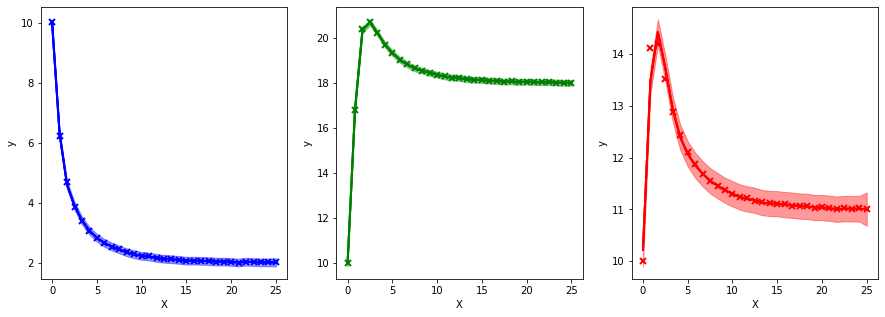

In [89]:
fit_model(X_aug,Y_aug,3,1,gpf.kernels.Matern32)

name,class,transform,prior,trainable,shape,dtype,value
VGP.mean_function.w,Parameter,Identity,,True,"(1, 3)",float64,[[ 9.39915e+00 -4.07350e-01 5.79000e-03]]
VGP.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,7.00671
VGP.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,5.05133
VGP.kernel.kernels[1].W,Parameter,Identity,,True,"(3, 1)",float64,[[-3.89832] [ 8.55225] [ 4.1792 ]]
VGP.kernel.kernels[1].kappa,Parameter,Softplus,,True,"(3,)",float64,[0.10388 1.75205 0.19826]
VGP.likelihood.likelihoods[0].variance,Parameter,Softplus + Shift,,True,(),float64,0.0207
VGP.likelihood.likelihoods[1].variance,Parameter,Softplus + Shift,,True,(),float64,0.06398
VGP.likelihood.likelihoods[2].variance,Parameter,Softplus + Shift,,True,(),float64,0.10604
VGP.num_data,Parameter,Identity,,False,(),int32,93
VGP.q_mu,Parameter,Identity,,True,"(93, 1)",float64,[[3.57000e-02...


BIC: 30207.95969154168


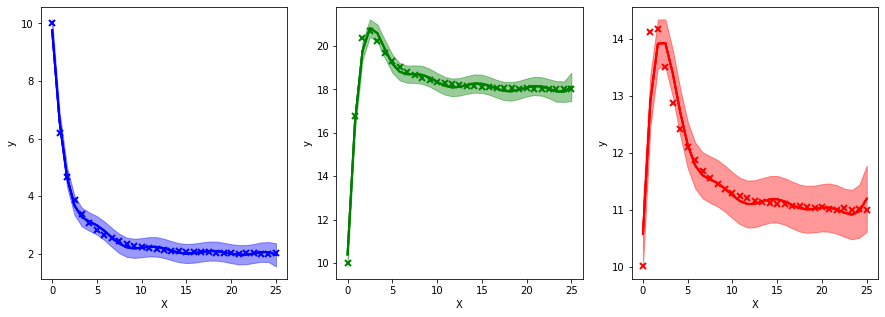

In [93]:
fit_model(X_aug,Y_aug,3,1,gpf.kernels.SquaredExponential, M_F=gpf.functions.Polynomial(2))

name,class,transform,prior,trainable,shape,dtype,value
VGP.mean_function.w,Parameter,Identity,,True,"(1, 3)",float64,[[ 9.37817e+00 -3.91270e-01 5.37000e-03]]
VGP.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,5.11576
VGP.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,4.60519
VGP.kernel.kernels[1].W,Parameter,Identity,,True,"(3, 2)",float64,"[[-2.96721, -2.96721..."
VGP.kernel.kernels[1].kappa,Parameter,Softplus,,True,"(3,)",float64,[0.18109 0.68267 0.11563]
VGP.likelihood.likelihoods[0].variance,Parameter,Softplus + Shift,,True,(),float64,0.01507
VGP.likelihood.likelihoods[1].variance,Parameter,Softplus + Shift,,True,(),float64,0.03527
VGP.likelihood.likelihoods[2].variance,Parameter,Softplus + Shift,,True,(),float64,0.08048
VGP.num_data,Parameter,Identity,,False,(),int32,93
VGP.q_mu,Parameter,Identity,,True,"(93, 1)",float64,[[0.04994...


BIC: 30188.997773384057


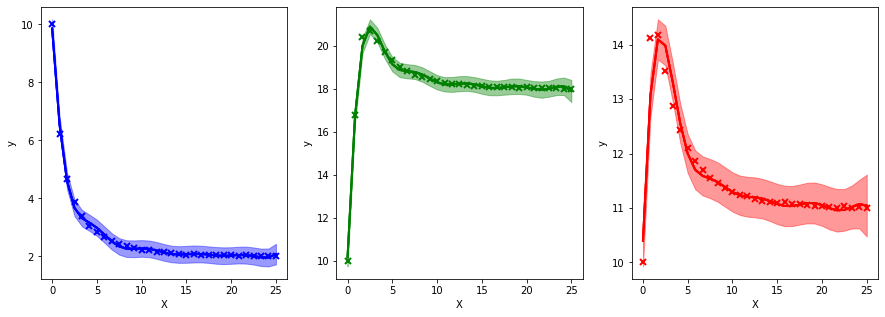

In [94]:
fit_model(X_aug,Y_aug,3,2,gpf.kernels.SquaredExponential, M_F=gpf.functions.Polynomial(2))

name,class,transform,prior,trainable,shape,dtype,value
VGP.mean_function.w,Parameter,Identity,,True,"(1, 3)",float64,[[ 4.26079 0.89998 -0.01673]]
VGP.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,4.28333
VGP.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,4.00029
VGP.kernel.kernels[1].W,Parameter,Identity,,True,"(3, 3)",float64,"[[-0.25485, -0.25485, -0.25485..."
VGP.kernel.kernels[1].kappa,Parameter,Softplus,,True,"(3,)",float64,[0.45973 3.43169 1.73756]
VGP.likelihood.likelihoods[0].variance,Parameter,Softplus + Shift,,True,(),float64,0.88966
VGP.likelihood.likelihoods[1].variance,Parameter,Softplus + Shift,,True,(),float64,8.2071
VGP.likelihood.likelihoods[2].variance,Parameter,Softplus + Shift,,True,(),float64,3.85351
VGP.num_data,Parameter,Identity,,False,(),int32,93
VGP.q_mu,Parameter,Identity,,True,"(93, 1)",float64,[[1.03334...


BIC: 30471.833641555877


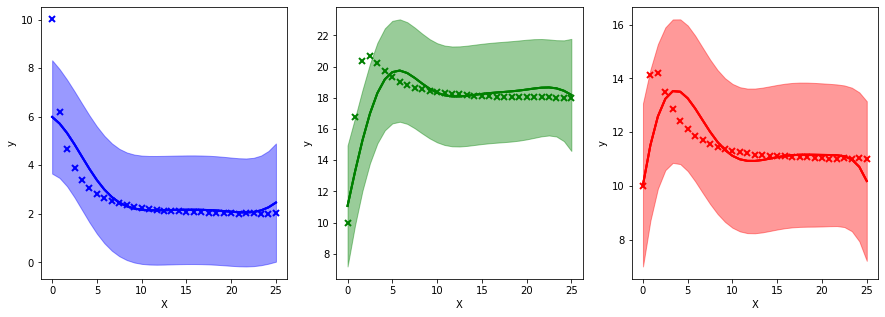

In [95]:
fit_model(X_aug,Y_aug,3,3,gpf.kernels.SquaredExponential, M_F=gpf.functions.Polynomial(2))